# Install Dependencies


In [ ]:
!pip install tensorflow==2.15.0 keras==2.15 tensorflow-hub==0.13.0 tensorflow-text==2.15.0
!pip install datasets
!pip -q install evaluate
!pip install imbalanced-learn
!pip install transformers datasets scikit-learn imbalanced-learn evaluate

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.layers import Input
import numpy as np


import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



# Tensor Flow

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Check if libraries are installed and print their versions
try:
    print(f"TensorFlow Hub Version: {hub.__version__}")
except ImportError:
    print("TensorFlow Hub is not installed.")

try:
    print(f"TensorFlow Text Version: {text.__version__}")
except ImportError:
    print("TensorFlow Text is not installed.")

try:
    print(f"TensorFlow Version: {tf.__version__}")
except ImportError:
    print("TensorFlow is not installed.")

try:
    print(f"pandas Version: {pd.__version__}")
except ImportError:
    print("pandas is not installed.")

try:
    print(f"scikit-learn Version: {train_test_split.__module__.split('.')[0]}")
except ImportError:
    print("scikit-learn is not installed.")

try:
    print(f"scikit-learn Version: {classification_report.__module__.split('.')[0]}")
except ImportError:
    print("scikit-learn is not installed.")

#other usefull

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import RandomOverSampler


# Import Libraries

from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict


import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




# Import Github

In [ ]:
!git clone https://github.com/tajuar-akash-hub/Datasets.git

# Dataset Location

In [ ]:
my_df_loc = '/kaggle/working/Datasets/sentence_without_gemini.csv'

# BERT Variations


## DistilBERT

In [ ]:
pip install --upgrade sympy


In [ ]:
data = pd.read_csv(my_df_loc)
# Drop missing values
data.dropna(inplace=True)

In [ ]:
data.columns

In [ ]:
# Split dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['generated_sentence_without_gemini'],  # Features
    data['fraud_status'],           # Labels
    test_size=0.2,                  # Proportion of test data
    stratify=data['fraud_status'],  # Stratify on fraud_status
    random_state=42                 # For reproducibility
)

In [ ]:
ros = RandomOverSampler(random_state=42)

# Combine texts and labels into a DataFrame for oversampling
train_data = pd.DataFrame({'text': train_texts, 'label': train_labels})

# Apply oversampling
oversampled_texts, oversampled_labels = ros.fit_resample(
    train_data[['text']], train_data['label']
)

# Flatten the oversampled_texts back into a list
oversampled_texts = oversampled_texts['text'].tolist()


In [ ]:
# Load ClinicalBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Tokenize the oversampled training data
train_encodings = tokenizer(oversampled_texts, truncation=True, padding=True, max_length=200)

# Tokenize the test data
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=200)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': oversampled_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels.tolist()
})


In [ ]:
# Load ClinicalBERT model

model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)


In [ ]:
training_args = TrainingArguments(
    output_dir="./clinicalbert-results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)  # Get predicted class indices
    
    # Metrics calculations
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="binary", zero_division=1)
    recall = recall_score(labels, predictions, average="binary", zero_division=1)
    f1 = f1_score(labels, predictions, average="binary", zero_division=1)
    mcc = matthews_corrcoef(labels, predictions)
    
    # Return all metrics
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mcc": mcc,
    }


In [135]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


<ipython-input-135-b292458b8898>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mcc
1,0.071600,0.047153,0.987705,0.833333,1.000000,0.909091,0.906872
2,0.003100,0.037423,0.993169,0.900000,1.000000,0.947368,0.945225
3,0.000800,0.022766,0.995902,0.956522,0.977778,0.967033,0.964914


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=516, training_loss=0.07473498701782132, metrics={'train_runtime': 275.9575, 'train_samples_per_second': 59.661, 'train_steps_per_second': 1.87, 'total_flos': 972976460500800.0, 'train_loss': 0.07473498701782132, 'epoch': 3.0})

In [136]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Classification Report
from sklearn.metrics import classification_report

y_pred = trainer.predict(test_dataset).predictions.argmax(axis=-1)
print(classification_report(test_labels, y_pred, target_names=["Not Fraud", "Fraud"]))


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.022766094654798508, 'eval_accuracy': 0.9959016393442623, 'eval_precision': 0.9565217391304348, 'eval_recall': 0.9777777777777777, 'eval_f1': 0.967032967032967, 'eval_mcc': 0.9649144927428774, 'eval_runtime': 3.636, 'eval_samples_per_second': 201.317, 'eval_steps_per_second': 6.326, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00       687
       Fraud       0.96      0.98      0.97        45

    accuracy                           1.00       732
   macro avg       0.98      0.99      0.98       732
weighted avg       1.00      1.00      1.00       732



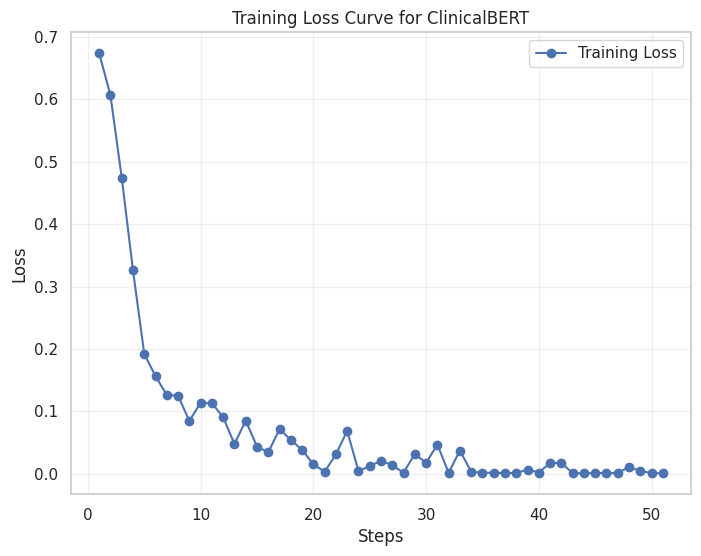

In [137]:
# Extract training loss
train_metrics = trainer.state.log_history
train_loss = [log['loss'] for log in train_metrics if 'loss' in log]

# Plot training loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', label='Training Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve for ClinicalBERT")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


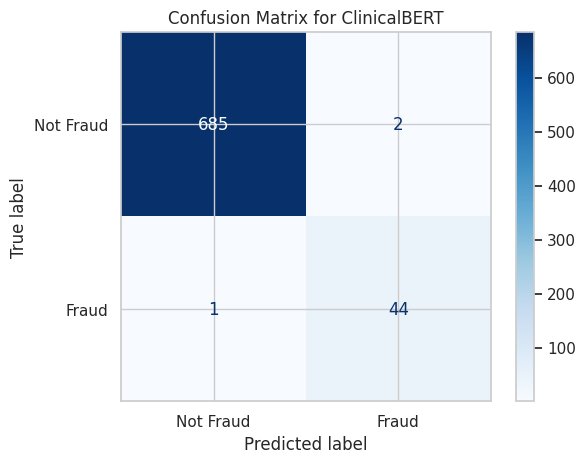

In [138]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Compute and display confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for ClinicalBERT")
plt.show()


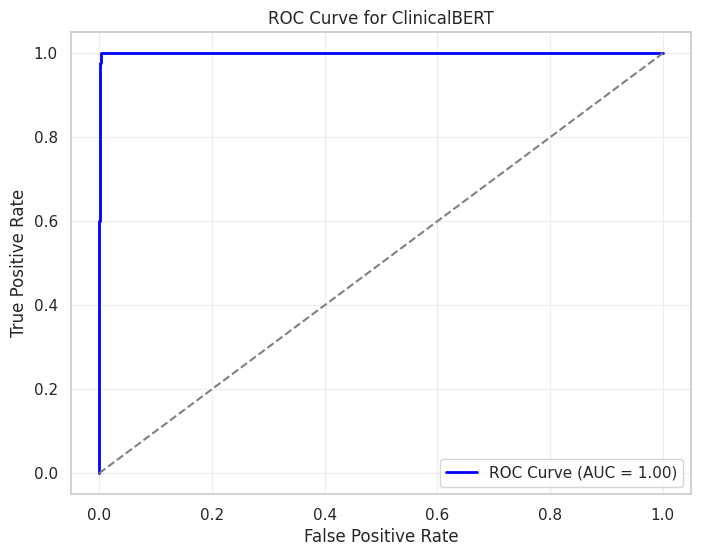

In [139]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for the positive class
predicted_probabilities = predictions.predictions[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ClinicalBERT")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


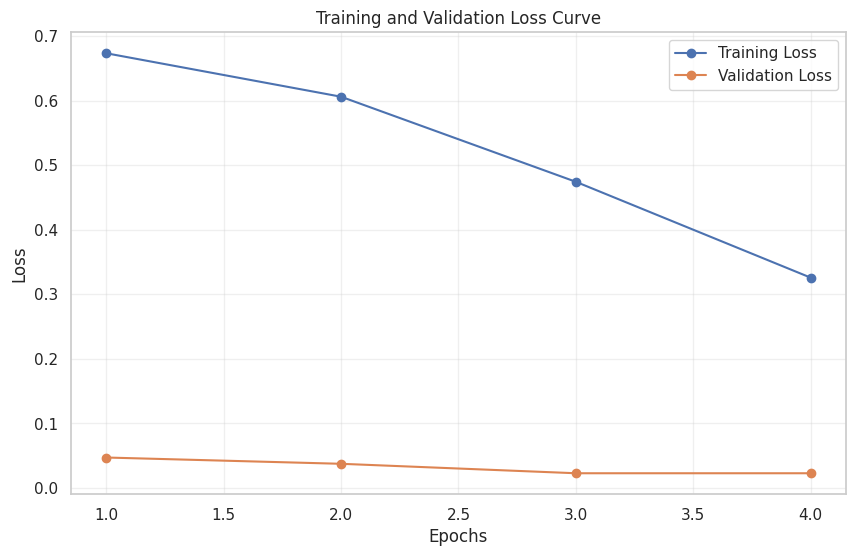

In [140]:
# Extract Training and Validation Losses from the Trainer's Log History
train_metrics = trainer.state.log_history

# Extract epoch-wise losses
train_loss = [log["loss"] for log in train_metrics if "loss" in log]
eval_loss = [log["eval_loss"] for log in train_metrics if "eval_loss" in log]

# Generate epochs for plotting
epochs = list(range(1, len(eval_loss) + 1))

# Plotting the Training and Validation Loss Curve
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss[:len(epochs)], marker="o", label="Training Loss")
plt.plot(epochs, eval_loss, marker="o", label="Validation Loss")
plt.title("Training and Validation Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
